In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from random import randint

In [2]:
def change_class(x):
    if x == "botnet":
        return 1
    elif x== "normal":
        return 0

    
def rename_ctu19_string_col(df):
    return df.rename({"domain":"State"},axis=1)
    

def drop_columns_ctu19(df):
    return df.drop(["modelsize","State"], axis=1)


def feature_vector(ctu_13):
    #Periodicity
    ctu_13["strong_p"] = ctu_13["State"].str.count('[a-i]')
    ctu_13["weak_p"] = ctu_13["State"].str.count('[A-I]')
    ctu_13["weak_np"] = ctu_13["State"].str.count('[r-z]')
    ctu_13["strong_np"] = ctu_13["State"].str.count('[R-Z]')
    #Duration
    ctu_13["duration_s"] = ctu_13["State"].str.count('(a|A|r|R|1|d|D|u|U|4|g|G|x|X|7)')
    ctu_13["duration_m"] = ctu_13["State"].str.count('(b|B|s|S|2|e|E|v|V|5|h|H|y|Y|8)')
    ctu_13["duration_l"] = ctu_13["State"].str.count('(c|C|t|T|3|f|F|w|W|6|i|I|z|Z|9)')
    #Size
    ctu_13["size_s"] = ctu_13["State"].str.count('[a-c]') + \
                        ctu_13["State"].str.count('[A-C]') + \
                        ctu_13["State"].str.count('[r-t]') + \
                        ctu_13["State"].str.count('[R-T]') + \
                        ctu_13["State"].str.count('[1-3]')
    ctu_13["size_m"] = ctu_13["State"].str.count('[d-f]') + \
                        ctu_13["State"].str.count('[D-F]') + \
                        ctu_13["State"].str.count('[u-w]') + \
                        ctu_13["State"].str.count('[U-W]') + \
                        ctu_13["State"].str.count('[4-6]')
    ctu_13["size_l"] = ctu_13["State"].str.count('[g-i]') + \
                        ctu_13["State"].str.count('[G-I]') + \
                        ctu_13["State"].str.count('[x-z]') + \
                        ctu_13["State"].str.count('[X-Z]') + \
                        ctu_13["State"].str.count('[7-9]')
    #Periodicity %
    ctu_13["strong_p"] = ctu_13["strong_p"]/ctu_13["modelsize"]
    ctu_13["weak_p"] = ctu_13["weak_p"]/ctu_13["modelsize"]
    ctu_13["strong_np"] = ctu_13["strong_np"]/ctu_13["modelsize"]
    ctu_13["weak_np"] = ctu_13["weak_np"]/ctu_13["modelsize"]
    #Duration %
    ctu_13["duration_s"] = ctu_13["duration_s"]/ctu_13["modelsize"]
    ctu_13["duration_m"] = ctu_13["duration_m"]/ctu_13["modelsize"]
    ctu_13["duration_l"] = ctu_13["duration_l"]/ctu_13["modelsize"]
    #Size %
    ctu_13["size_s"] = ctu_13["size_s"]/ctu_13["modelsize"]
    ctu_13["size_m"] = ctu_13["size_m"]/ctu_13["modelsize"]
    ctu_13["size_l"] = ctu_13["size_l"]/ctu_13["modelsize"]
    return ctu_13


def remove_chars_until(df, k):
    df["State"] = df["State"].apply(lambda x: x[k:])
    return df


def clean_ctu_13(df):
    df["class"] = df["class"].apply(change_class)
    df.drop(["src","dst","port","proto","label","modelsize","State"], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df


def prepare_resuls_for_plot(df):
    df.drop("support", axis=1, inplace=True)
    df["Specificity"] = df.iloc[0::2]["recall"]
    df["Specificity"] = df["Specificity"].shift(1)
    return df.iloc[1::2]


def cut_string_until(df, k):
    df["State"] = df["State"].apply(lambda x: x[:k])
    return df

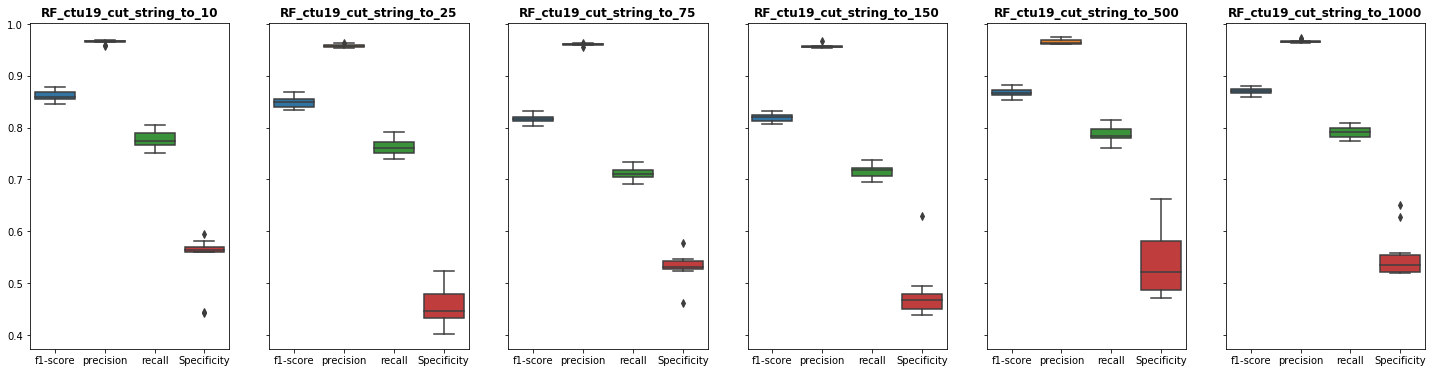

In [22]:
sizes_string = [10, 25, 75, 150, 500, 1000]

#For plotting all results together
fig, axes = plt.subplots(1, len(sizes_string), figsize=(25,6), sharey=True)

for k, str_size in enumerate(sizes_string):
    #Read raw datasets
    ctu_13 = pd.read_csv("../Datasets/ctu-13.labeled.cleaned.csv")
    ctu_19 = pd.read_csv("../Datasets/change_of_context/ctu19_to_test_RF.csv")
    
    #Prepare ctu_13
    ctu_13 = (ctu_13.pipe(remove_chars_until,3)
                    .pipe(cut_string_until, str_size)
                    .pipe(feature_vector)
                    .pipe(clean_ctu_13))

    #Prepare ctu_19
    ctu_19 = (ctu_19.pipe(rename_ctu19_string_col)
                    .pipe(cut_string_until, str_size)
                    .pipe(feature_vector)
                    .pipe(drop_columns_ctu19))

    #10 runs for variability testing
    for i in range(10):
        #Divide train-test dataset
        x = ctu_13.drop('class',axis=1)
        y = ctu_13['class']
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        #Testing is now from ctu_19
        X_test = ctu_19.drop('class',axis=1)
        y_test = ctu_19['class']

        #Training
        rfc = RandomForestClassifier(n_estimators=100)
        rfc.fit(X_train, y_train)

        #Testing
        rfc_pred = rfc.predict(X_test)
        #print(confusion_matrix(y_test,rfc_pred))
        #print(classification_report(y_test,rfc_pred))

        #Save results
        report = classification_report(y_test,rfc_pred,
                target_names=["normal","botnet"], digits=4, output_dict=True)
        df = pd.DataFrame(report).transpose()
        name = "../Datasets/change_of_context/results_RF_cut_string_to_"+str(str_size)+".csv"
        if i == 0:
            df.iloc[[0,1]].to_csv(name, index=False, header=True)
        else:
            df.iloc[[0,1]].to_csv(name ,index=False, mode="a", header=False)

    #Make single plot of results
    df = pd.read_csv(name)
    df = (df.pipe(prepare_resuls_for_plot))
    sns.boxplot(data=df.iloc[:,0:4], ax=axes[k])
    axes[k].set_title('RF_ctu19_cut_string_to_'+str(str_size),fontweight="bold")

#Show all the runs    
plt.show()